<a href="https://colab.research.google.com/github/a-n-u-r-a-g/Protecting-FinTech-Platforms-from-Advanced-Persistent-Threats-and-Financial-Data-Breaches/blob/main/CICIDS_2017_Network_Intrusion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightgbm xgboost catboost scikit-learn seaborn matplotlib --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier


In [ ]:
# Load the datasets
from google.colab import files
uploaded = files.upload()

Saving cicids_2017.csv to cicids_2017.csv


In [ ]:
# Load CSV
df = pd.read_csv('/content/cicids_2017.csv')
print("Rows × Cols:", df.shape)
df.head()


Rows × Cols: (1042557, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
print(df.columns.tolist())


[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag 

In [ ]:
# ✅ Step 4: Preprocessing — Clean, Encode, Handle NaNs and Scale

# 1. Rename the label column and encode it (BENIGN → 0, attack → 1)
df.rename(columns={' Label': 'target'}, inplace=True)
df['target'] = df['target'].map(lambda x: 1 if x != 'BENIGN' else 0)

# 2. One-hot encode categorical columns (if any)
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col != 'target']
df = pd.get_dummies(df, columns=categorical_cols)

# Separate features and target variable
X = df.drop(columns=['target'])
y = df['target']

# Split the dataset BEFORE handling infinite values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle infinite and missing values in BOTH training and testing sets
X_train = X_train.replace([np.inf, -np.inf], np.nan) # Replace infinite values with NaN
X_train = X_train.fillna(X_train.mean()) # Fill NaN values with the mean of each column

X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = X_test.fillna(X_test.mean())

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Further split the training dataset to create X_train_part and y_train_part
X_train_part, _, y_train_part, _ = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)


In [ ]:
# Use the full training set (not X_train_part)
rf    = RandomForestClassifier(random_state=42)
xgb_m = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
lgbm  = lgb.LGBMClassifier()
cat   = CatBoostClassifier(verbose=0)

# Train models on full training set
for model in [rf, xgb_m, lgbm, cat]:
    model.fit(X_train_scaled, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:48:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 330841, number of negative: 503204
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.238344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14560
[LightGBM] [Info] Number of data points in the train set: 834045, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.396670 -> initscore=-0.419358
[LightGBM] [Info] Start training from score -0.419358


In [ ]:
# Step 6: Ensemble predictions (Soft voting)
proba_outputs = np.vstack([
    rf.predict_proba(X_test_scaled)[:,1],
    xgb_m.predict_proba(X_test_scaled)[:,1],
    lgbm.predict_proba(X_test_scaled)[:,1],
    cat.predict_proba(X_test_scaled)[:,1]
]).T  # shape: (n_samples, 4)

# Train a meta-model on these probabilities
meta = LogisticRegression()
meta.fit(proba_outputs, y_test)

# Final predictions
y_pred = meta.predict(proba_outputs)
y_proba = meta.predict_proba(proba_outputs)[:,1]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Step 7: Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

acc   = accuracy_score(y_test, y_pred)
prec  = precision_score(y_test, y_pred)
rec   = recall_score(y_test, y_pred)
f1    = f1_score(y_test, y_pred)
roc   = roc_auc_score(y_test, y_proba)

print("📊 CICIDS Ensemble Meta-Model Metrics")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc:.4f}\n")

print("Classification Report:\n", classification_report(y_test, y_pred))


📊 CICIDS Ensemble Meta-Model Metrics
Accuracy:  0.9998
Precision: 0.9997
Recall:    0.9999
F1-Score:  0.9998
ROC-AUC:   1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    125870
           1       1.00      1.00      1.00     82642

    accuracy                           1.00    208512
   macro avg       1.00      1.00      1.00    208512
weighted avg       1.00      1.00      1.00    208512



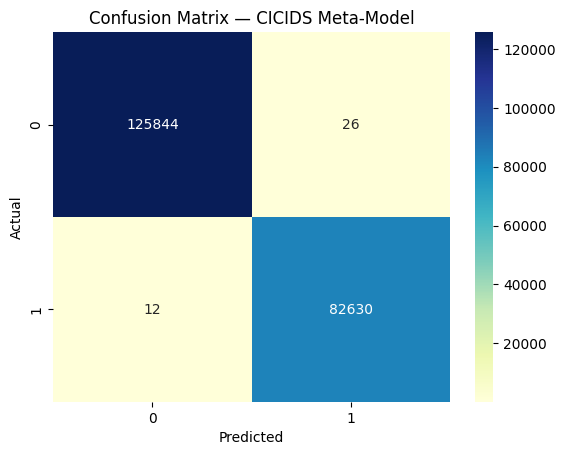

In [ ]:
# Confusion Matrix Plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix — CICIDS Meta-Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


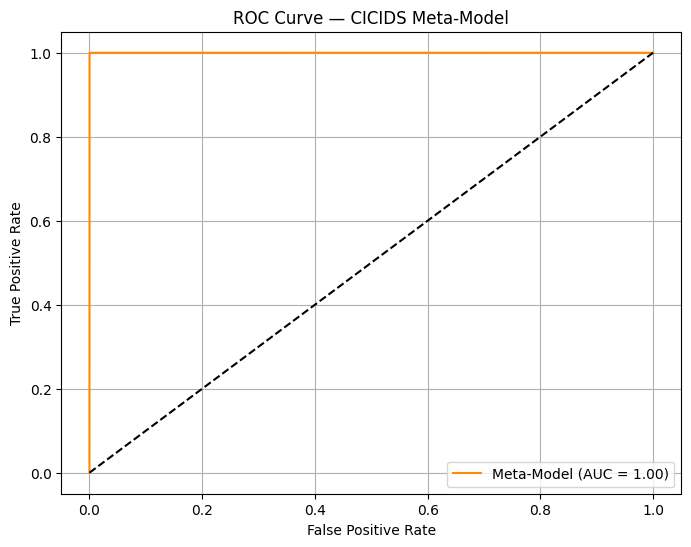

In [ ]:
# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"Meta-Model (AUC = {roc:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve — CICIDS Meta-Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
# Step 8: Real-time Alert Simulation
def alert_net(prob, threshold=0.5):
    return "🚨 Fraud Detected" if prob >= threshold else "✅ Legitimate Transaction"

# Test on a few examples
for i in range(5):  # Change the range to test more examples
    print(f"Sample {i + 1}: Probability = {y_proba[i]:.4f} → {alert_net(y_proba[i])}")


Sample 1: Probability = 0.9996 → 🚨 Fraud Detected
Sample 2: Probability = 0.0002 → ✅ Legitimate Transaction
Sample 3: Probability = 0.0002 → ✅ Legitimate Transaction
Sample 4: Probability = 0.0002 → ✅ Legitimate Transaction
Sample 5: Probability = 0.0002 → ✅ Legitimate Transaction


In [ ]:
import joblib

# Save the models
joblib.dump(rf, 'random_forest_model.pkl')
joblib.dump(xgb_m, 'xgboost_model.pkl')
joblib.dump(lgbm, 'lightgbm_model.pkl')
joblib.dump(cat, 'catboost_model.pkl')
joblib.dump(meta, 'meta_model.pkl')

print("Models saved successfully!")


Models saved successfully!


In [ ]:
rf = joblib.load('random_forest_model.pkl')
xgb_m = joblib.load('xgboost_model.pkl')
lgbm = joblib.load('lightgbm_model.pkl')
cat = joblib.load('catboost_model.pkl')
meta = joblib.load('meta_model.pkl')
